In [10]:
!pip install kaggle torch torchvision numpy matplotlib seaborn shap lime opencv-python


In [11]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
DATASET_PATH = "/kaggle/input/melanoma-cancer-dataset"
train_dir = os.path.join(DATASET_PATH, "train")
val_dir = os.path.join(DATASET_PATH, "test")

In [13]:
transform_train = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
trainset = datasets.ImageFolder(root=train_dir, transform=transform_train)
valset = datasets.ImageFolder(root=val_dir, transform=transform_val)

# Check Class Distribution
class_counts = np.bincount([label for _, label in trainset])
print(f"Class Counts: {class_counts}")

# Compute Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique([label for _, label in trainset]), y=[label for _, label in trainset])
class_weights = torch.tensor(class_weights, dtype=torch.float)

Class Counts: [6289 5590]


In [15]:
# Sampler for Balancing Dataset
weights = [1.0 / class_counts[label] for _, label in trainset]
sampler = WeightedRandomSampler(weights, num_samples=len(trainset), replacement=True)

# Data Loaders
batch_size = 16
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

In [16]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained EfficientNet-B4
model = models.efficientnet_b4(weights="IMAGENET1K_V1")
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(trainset.classes))  # Output for 2 classes
)

model = model.to(device)


In [17]:
import torch.optim as optim

# Loss Function with Class Weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# AdamW Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [18]:
from tqdm import tqdm

epochs = 20
best_acc = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(" Model Saved!")

    scheduler.step()



Epoch 1/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.3308, Train Accuracy: 0.8563


100%|██████████| 125/125 [00:13<00:00,  9.25it/s]


Validation Loss: 0.2233, Validation Accuracy: 0.9180
 Model Saved!

Epoch 2/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.2526, Train Accuracy: 0.8944


100%|██████████| 125/125 [00:13<00:00,  9.32it/s]


Validation Loss: 0.2081, Validation Accuracy: 0.9170

Epoch 3/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.2213, Train Accuracy: 0.9106


100%|██████████| 125/125 [00:13<00:00,  9.29it/s]


Validation Loss: 0.1620, Validation Accuracy: 0.9420
 Model Saved!

Epoch 4/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.2030, Train Accuracy: 0.9156


100%|██████████| 125/125 [00:13<00:00,  9.39it/s]


Validation Loss: 0.1974, Validation Accuracy: 0.9305

Epoch 5/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.1797, Train Accuracy: 0.9247


100%|██████████| 125/125 [00:13<00:00,  9.31it/s]


Validation Loss: 0.1636, Validation Accuracy: 0.9360

Epoch 6/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.1623, Train Accuracy: 0.9318


100%|██████████| 125/125 [00:13<00:00,  9.27it/s]


Validation Loss: 0.1615, Validation Accuracy: 0.9380

Epoch 7/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.1586, Train Accuracy: 0.9331


100%|██████████| 125/125 [00:13<00:00,  9.33it/s]


Validation Loss: 0.1700, Validation Accuracy: 0.9355

Epoch 8/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.1365, Train Accuracy: 0.9429


100%|██████████| 125/125 [00:13<00:00,  9.35it/s]


Validation Loss: 0.1531, Validation Accuracy: 0.9405

Epoch 9/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.1430, Train Accuracy: 0.9432


100%|██████████| 125/125 [00:13<00:00,  9.23it/s]


Validation Loss: 0.1575, Validation Accuracy: 0.9400

Epoch 10/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.1408, Train Accuracy: 0.9425


100%|██████████| 125/125 [00:13<00:00,  9.25it/s]


Validation Loss: 0.1553, Validation Accuracy: 0.9405

Epoch 11/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.1412, Train Accuracy: 0.9384


100%|██████████| 125/125 [00:13<00:00,  9.32it/s]


Validation Loss: 0.1540, Validation Accuracy: 0.9415

Epoch 12/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.1341, Train Accuracy: 0.9460


100%|██████████| 125/125 [00:13<00:00,  9.31it/s]


Validation Loss: 0.1486, Validation Accuracy: 0.9435
 Model Saved!

Epoch 13/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.1354, Train Accuracy: 0.9458


100%|██████████| 125/125 [00:13<00:00,  9.27it/s]


Validation Loss: 0.1583, Validation Accuracy: 0.9395

Epoch 14/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.1367, Train Accuracy: 0.9448


100%|██████████| 125/125 [00:13<00:00,  9.25it/s]


Validation Loss: 0.1501, Validation Accuracy: 0.9405

Epoch 15/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.1271, Train Accuracy: 0.9476


100%|██████████| 125/125 [00:13<00:00,  9.29it/s]


Validation Loss: 0.1477, Validation Accuracy: 0.9385

Epoch 16/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.1214, Train Accuracy: 0.9508


100%|██████████| 125/125 [00:13<00:00,  9.29it/s]


Validation Loss: 0.1561, Validation Accuracy: 0.9390

Epoch 17/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.1237, Train Accuracy: 0.9496


100%|██████████| 125/125 [00:13<00:00,  9.25it/s]


Validation Loss: 0.1549, Validation Accuracy: 0.9390

Epoch 18/20


100%|██████████| 743/743 [04:55<00:00,  2.52it/s]


Train Loss: 0.1129, Train Accuracy: 0.9542


100%|██████████| 125/125 [00:13<00:00,  9.24it/s]


Validation Loss: 0.1380, Validation Accuracy: 0.9495
 Model Saved!

Epoch 19/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.1112, Train Accuracy: 0.9556


100%|██████████| 125/125 [00:13<00:00,  9.33it/s]


Validation Loss: 0.1410, Validation Accuracy: 0.9480

Epoch 20/20


100%|██████████| 743/743 [04:55<00:00,  2.51it/s]


Train Loss: 0.1054, Train Accuracy: 0.9565


100%|██████████| 125/125 [00:13<00:00,  9.23it/s]

Validation Loss: 0.1444, Validation Accuracy: 0.9465


In [23]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load Best Model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Evaluate on Test Data
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of Malignant

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# Calculate Metrics
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Results
print(f" Test Accuracy: {test_accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")


<ipython-input-23-328b18b03b12>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


 Test Accuracy: 0.9495
 Precision: 0.9504
 Recall: 0.9495
 F1 Score: 0.9495


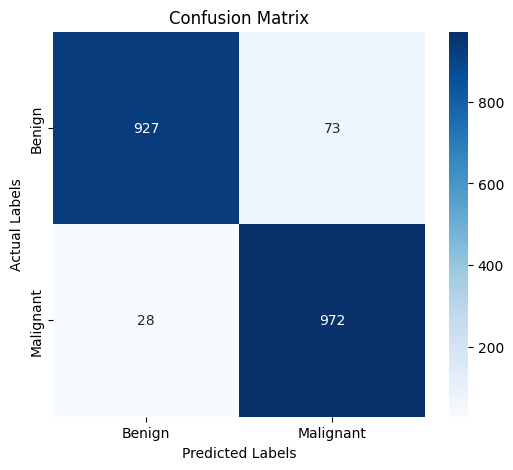

In [24]:
# Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


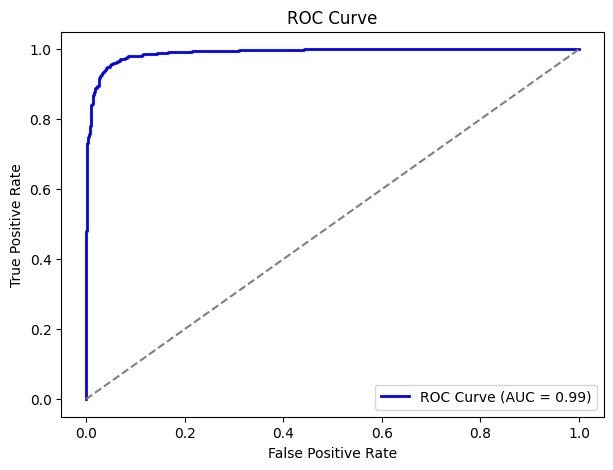

In [25]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [27]:

# Classification Report
print(classification_report(y_true, y_pred, target_names=trainset.classes))

              precision    recall  f1-score   support

      Benign       0.97      0.93      0.95      1000
   Malignant       0.93      0.97      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



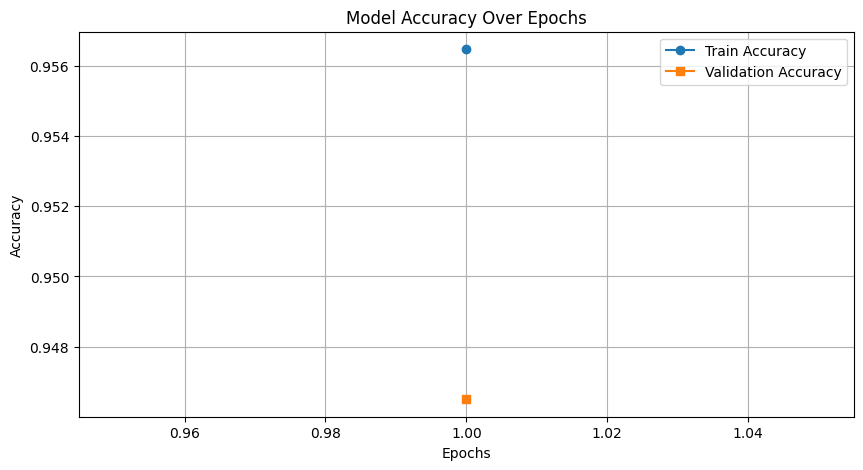

In [50]:
import matplotlib.pyplot as plt

# Ensure train_acc and val_acc are lists
if isinstance(train_acc, float):
    train_acc = [train_acc]  # Convert to list if only a single value exists

if isinstance(val_acc, float):
    val_acc = [val_acc]  # Convert to list if only a single value exists

epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


  

  

  0%|          | 0/1000 [00:00<?, ?it/s]

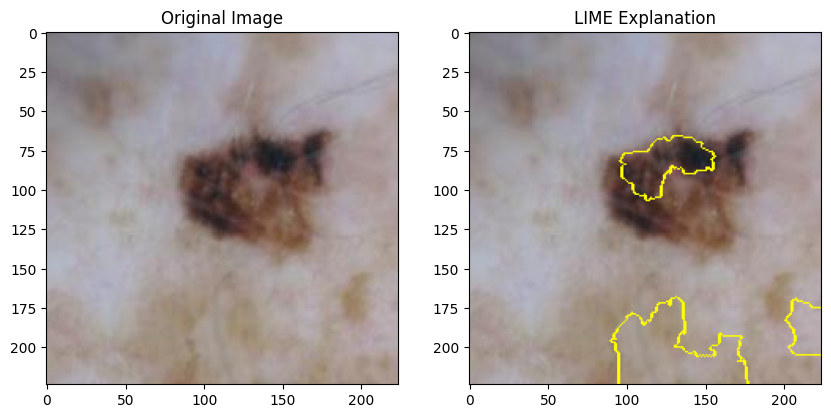

In [57]:
import lime
import lime.lime_image
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image

#  Load model and move to CPU
model.cpu()
model.eval()

# Define function for LIME
def predict_fn(images):
    images = torch.tensor(images, dtype=torch.float32)  # Ensure CPU tensor
    images = images.permute(0, 3, 1, 2)  # Convert from (H, W, C) to (C, H, W)
    outputs = model(images)  # Model on CPU
    return torch.nn.functional.softmax(outputs, dim=1).detach().numpy()

#  Load an image
image_path = "/kaggle/input/melanoma-cancer-dataset/test/Malignant/5627.jpg"  # Change to actual test image
orig_image = Image.open(image_path).convert("RGB")

# Preprocess image
transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor()
])
image_tensor = transform(orig_image).unsqueeze(0)  # Shape: (1, C, H, W)

# Convert image to NumPy for LIME
image_np = np.array(orig_image)

#  Initialize LIME explainer
explainer = lime.lime_image.LimeImageExplainer()

#  Explain the prediction
explanation = explainer.explain_instance(image_np, predict_fn, top_labels=2, hide_color=0, num_samples=1000)

#  Visualize explanation
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(orig_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")

plt.show()


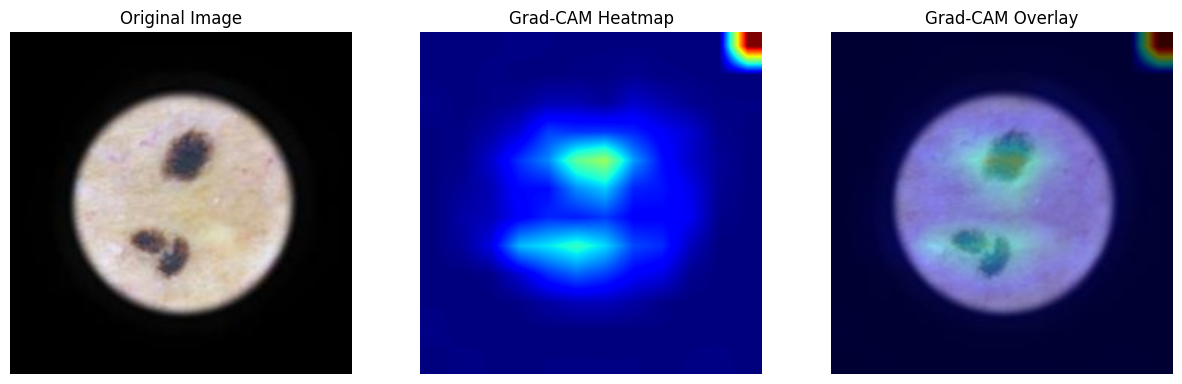

In [32]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

#  Load EfficientNet-B4
model = models.efficientnet_b4(weights="IMAGENET1K_V1")
model.eval()

#  Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#  Define Image Preprocessing (for EfficientNet)
transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#  Load and Preprocess Image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Convert to RGB
    img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim
    return img_tensor, np.array(image)

#  Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hook to get activations
        def forward_hook(module, input, output):
            self.activations = output

        # Hook to get gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Register hooks on target layer
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx=None):
        input_tensor.requires_grad = True  # Ensure gradients can be computed

        # Forward pass
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()  # Get predicted class

        # Backpropagate for target class
        self.model.zero_grad()
        output[0, class_idx].backward(retain_graph=True)

        # Compute Grad-CAM
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)  # Global average pooling of gradients
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # Weighted sum of activations
        cam = F.relu(cam)  # Apply ReLU
        cam = cam.squeeze().cpu().detach().numpy()  # Convert to NumPy

        # Normalize heatmap
        cam = cv2.resize(cam, (380, 380))  # Resize to match input size
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize between 0-1
        return cam

# Select the Last Convolutional Layer (EfficientNet uses 'features' block)
target_layer = model.features[-1]

#  Initialize Grad-CAM
gradcam = GradCAM(model, target_layer)

#  Visualizing Grad-CAM
def visualize_gradcam(image_path):
    img_tensor, orig_img = preprocess_image(image_path)
    
    # Generate Grad-CAM heatmap
    heatmap = gradcam.generate_heatmap(img_tensor)
    
    # Convert heatmap to color
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    #  Fix Shape Issue: Ensure `orig_img` is (380, 380, 3)
    orig_img_resized = cv2.resize(orig_img, (380, 380))  # Resize to match heatmap size

    #  Fix Channel Issue: Ensure `orig_img` is 3-channel RGB
    if len(orig_img_resized.shape) == 2:
        orig_img_resized = cv2.cvtColor(orig_img_resized, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB

    # Fix Overlay Issue: Ensure both images are the same shape
    overlay = cv2.addWeighted(orig_img_resized.astype(np.uint8), 0.6, heatmap_colored.astype(np.uint8), 0.4, 0)

    # Plot results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(orig_img_resized)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(heatmap, cmap="jet")
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis("off")

    ax[2].imshow(overlay)
    ax[2].set_title("Grad-CAM Overlay")
    ax[2].axis("off")

    plt.show()

# Example Usage
image_path = "/kaggle/input/melanoma-cancer-dataset/test/Malignant/5618.jpg"  # Replace with your test image path
visualize_gradcam(image_path)
